In [1]:
import re
import time
import pickle
import numpy as np
import pandas as pd
from pprint import pprint

import spacy
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaMulticore

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# # Plotting tools
# import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
#from dask import dataframe as dd

In [2]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [3]:
def title_to_words(titles):
    for title in titles:
        yield(gensim.utils.simple_preprocess(str(title), deacc=True))  # deacc=True removes punctuations

In [4]:
# # See trigram example
# print(trigram_mod[bigram_mod[data_words[0]]])

In [5]:
def bigram_trigram_model(data_words):
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    return bigram_mod, trigram_mod

In [6]:
def remove_stopwords(text):
    return [word for word in text if word not in stop_words]

def make_bigrams(text, bigram_mod):
    return bigram_mod[text]

def make_trigrams(text, trigram_mod):
    return trigram_mod[bigram_mod[text]]

def lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    doc = nlp(" ".join(text)) 
    texts_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return texts_out

In [19]:
def prepare_text_for_lda(titles):
    title_words = list(title_to_words(titles))
    #del titles
    print("Done First")
    bigram_mod, trigram_mod = bigram_trigram_model(title_words)
    print("Done Second")
    title_words_nostops = list(map(remove_stopwords,title_words))
    del title_words
    print("Done Third")
    title_words_bigrams = [make_bigrams(text, bigram_mod) for text in title_words_nostops]
    del title_words_nostops
    print("Done Fourth")
    #title_lemmatized = list(map(lemmatization, title_words_bigrams))
    title_lemmatized = title_words_bigrams
    del title_words_bigrams
    print("Finished")
    return title_lemmatized

In [20]:
def create_corpus(data_lemmatized):
    id2word = corpora.Dictionary(data_lemmatized)
    id2word.filter_extremes(no_below=10, no_above=0.5)#no_below=2
    texts  = data_lemmatized
    corpus = [id2word.doc2bow(text) for text in texts]
    return (id2word, texts, corpus)

In [38]:
def save_model(lda_model, id2word, corpus):
    lda_model.save('topic_model_dblp.gensim')
    id2word.save('dictionary_dblp.gensim')
    pickle.dump(corpus, open('corpus_dblp.pkl', 'wb'))
    print("Model saved")
    return

In [22]:
#pprint(lda_model.print_topics())

In [23]:
# new_doc = ['Practical Bayesian Optimization of Machine Learning Algorithms']
# new_doc = prepare_text_for_lda(new_doc)
# new_doc_bow = [id2word.doc2bow(doc) for doc in new_doc]
# print(new_doc_bow)
# print(list(lda_model.get_document_topics(new_doc_bow)))

In [24]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):
    coherence_values = []
    #model_list = []
    perplexity = []
    topics     = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, 
                             num_topics=num_topics, workers = 8, passes=10, random_state=100)
        #model_list.append(model)
        perplexity.append(model.log_perplexity(corpus))
        topics.append(num_topics)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return perplexity, coherence_values, topics

In [35]:
def plot(perplexity, coherence_values, topics):
    _=plt.plot(topics, coherence_values, label="u_mass")
    _=plt.plot(topics, perplexity, label="perplexity")
    _=plt.xlabel('Number of Topics')
    _=plt.ylabel('Score')
    plt.legend()
    plt.savefig('score_dblp.pdf')
    plt.show()

In [31]:
def plot_perplexity(perplexity, topics):
    _=plt.plot(topics, perplexity, label="perplexity")
    _=plt.xlabel('Number of Topics')
    _=plt.ylabel('Score')
    plt.legend()
    plt.show()

In [33]:
def plot_coherence(coherence_values, topics):
    _=plt.plot(topics, coherence_values, label="u_mass")
    _=plt.xlabel('Number of Topics')
    _=plt.ylabel('Score')
    plt.legend()
    plt.show()

Started...
time taken (in hr)= 0.005107804271909926
Done First
Done Second
Done Third
Done Fourth
Finished
time taken (in hr)= 0.16375110805034637
Training....
time taken (in hr)= 3.3344145231114495

Perplexity:  -13.880627150959528
time taken (in hr)= 3.4866796171665193

Coherence Score:  -5.119463170727565
optimal number of topic calculation..


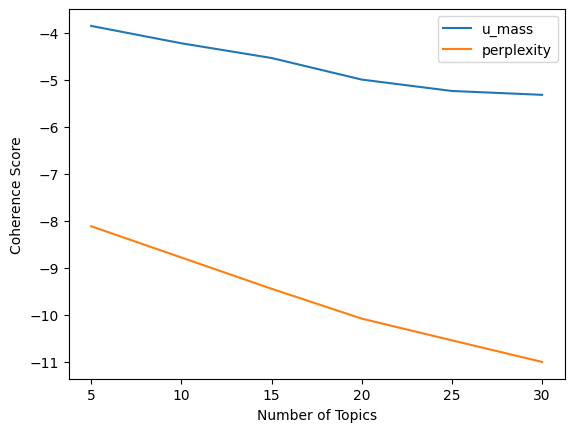

time taken (in hr)= 6.928972072137727


In [29]:
if __name__ == "__main__":
    print("Started...")
    start_time = time.time()
    folder = "../data/mgp_data/"
    publication = pd.read_csv(folder+"dblp_publication_data_for_mgp_researchers.csv")
    publication["clean_title"] = hero.clean(publication["title"])
    publication["clean_title"] = hero.stem(publication["clean_title"])
    publication1 = publication.groupby(["author_id","publication_year"])
    ['clean_title'].apply(list).reset_index(name='yearwise_titles').copy()
    del publication
    #publication = publication.sample(1000)
    titles = [title for year_titles in publication1["yearwise_titles"].values.tolist() for title in year_titles]
    #publication = publication.sample(1000)
    del publication1
    print(f"time taken (in minutes)= {(time.time() - start_time)/60}")
    data_lemmatized = prepare_text_for_lda(titles)
    
    id2word, texts, corpus = create_corpus(data_lemmatized)
    print(f"time taken (in minutes)= {(time.time() - start_time)/60}")
    print("Training...")
    lda_model = LdaMulticore(corpus=corpus,
                               id2word=id2word,
                               num_topics=20,
                               random_state=99,
                               chunksize=1000,
                               passes=10,
                               workers = 8
                            )
    print(f"time taken (in minutes)= {(time.time() - start_time)/60}")
    
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  #lower is better
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f"time taken (in minutes)= {(time.time() - start_time)/60}")
    print('\nCoherence Score: ', coherence_lda)
    print("optimal number of topic calculation...")
    perplexity, coherence_values, topics = compute_coherence_values(id2word, corpus, texts, 35)
    plot(perplexity, coherence_values, topics)
    save_model(lda_model, id2word, corpus)
    print(f"time taken (in minutes)= {(time.time() - start_time)/60}")

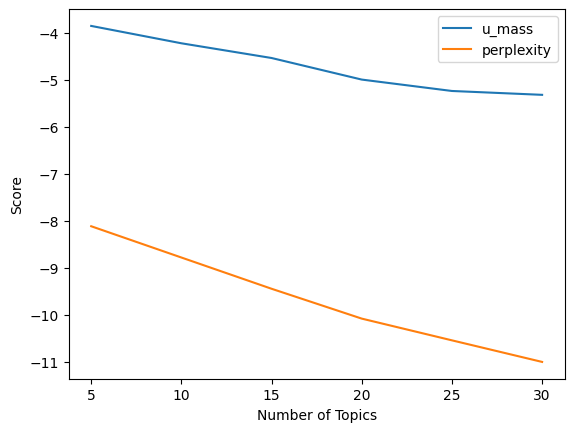

In [36]:
plot(perplexity, coherence_values, topics)

In [39]:
save_model(lda_model, id2word, corpus)

Model saved


In [30]:
perplexity

[-8.11179234413374,
 -8.776360688769083,
 -9.440630496742463,
 -10.07521873729786,
 -10.537131686927957,
 -10.995858652423431]

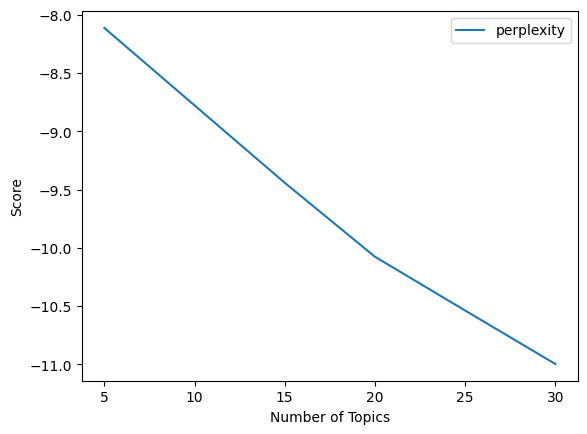

In [32]:
plot_perplexity(perplexity, topics)

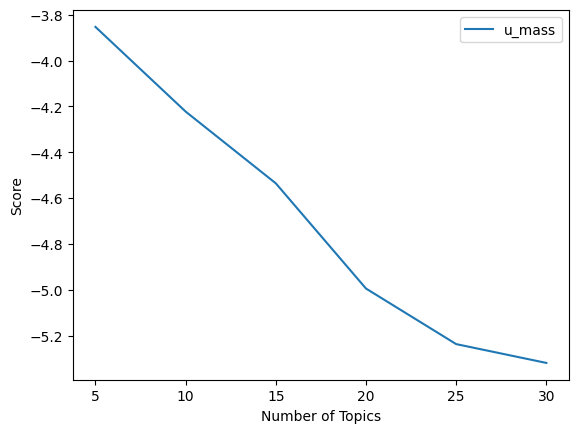

In [34]:
plot_coherence(coherence_values, topics)